# 1. Prelimnaries

In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import matplotlib.colors as mcolors
from collections import defaultdict
import pycountry_convert as pc
import copy
from scipy.stats import lognorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from scipy.stats import pearsonr, spearmanr
from collections import Counter
from matplotlib.colors import PowerNorm, TwoSlopeNorm
import matplotlib as mpl
from io import BytesIO
import base64
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from functions import get_inequity_df, build_all_networks_trade_volume, compute_node_inequity, build_all_directed_networks, enforce_min_node_distance, create_combined_plots, clean_weights, compute_cumulative_metric, compute_strengths, pearson_wrapper, custom_nmi_wrapper, convert_sim_result_to_graph, scaling_gamma, plot_cumulative_node_strength_from_graph, plot_cumulative_link_weight_from_graph, plot_avg_sorted_node_strength, plot_avg_sorted_link_weight, compute_group_weights, plot_inequity_and_degree, plot_trophic_overview, plot_all_rich_club
from matplotlib.lines import Line2D

# Loading dataframes
merged_df = pd.read_csv('Data/Total/merged_df.csv')
df_total = merged_df[['Source','Target','year','trade_share']].rename(columns={'trade_share':'weight'})
df_total_ghg = merged_df[['Source','Target','year','ghg_share']].rename(columns={'ghg_share':'weight'})

merged_df_primary = pd.read_csv('Data/Primary/merged_df_primary.csv')
df_primary = merged_df_primary[['Source','Target','year','trade_share']].rename(columns={'trade_share':'weight'})
df_primary_ghg = merged_df_primary[['Source','Target','year','ghg_share']].rename(columns={'ghg_share':'weight'})

merged_df_services = pd.read_csv('Data/Services/merged_df_services.csv')
df_services = merged_df_services[['Source','Target','year','trade_share']].rename(columns={'trade_share':'weight'})
df_services_ghg = merged_df_services[['Source','Target','year','ghg_share']].rename(columns={'ghg_share':'weight'})

merged_df_secondary = pd.read_csv('Data/Secondary/merged_df_secondary.csv')
df_secondary = merged_df_services[['Source','Target','year','trade_share']].rename(columns={'trade_share':'weight'})
df_secondary_ghg = merged_df_secondary[['Source','Target','year','ghg_share']].rename(columns={'ghg_share':'weight'})

# Unidrected Networks
G = build_all_networks_trade_volume(df_total, range(1995,2021), weight_col='weight')
G_ghg = build_all_networks_trade_volume(df_total_ghg, range(1995,2021), weight_col='weight')
G_primary = build_all_networks_trade_volume(df_primary, range(1995,2021), weight_col='weight')
G_primary_ghg = build_all_networks_trade_volume(df_primary_ghg, range(1995,2021), weight_col='weight')
G_services = build_all_networks_trade_volume(df_services, range(1995,2021), weight_col='weight')
G_services_ghg = build_all_networks_trade_volume(df_services_ghg, range(1995,2021), weight_col='weight')
G_secondary = build_all_networks_trade_volume(df_secondary, range(1995,2021), weight_col='weight')
G_secondary_ghg = build_all_networks_trade_volume(df_secondary_ghg, range(1995,2021), weight_col='weight')

# Directed Networks
G_dir = build_all_directed_networks(df_total, range(1995,2021), weight_col='weight')
G_ghg_dir = build_all_directed_networks(df_total_ghg, range(1995,2021), weight_col='weight')
G_primary_dir = build_all_directed_networks(df_primary, range(1995,2021), weight_col='weight')
G_primary_ghg_dir = build_all_directed_networks(df_primary_ghg, range(1995,2021), weight_col='weight')
G_services_dir = build_all_directed_networks(df_services, range(1995,2021), weight_col='weight')
G_services_ghg_dir = build_all_directed_networks(df_services_ghg, range(1995,2021), weight_col='weight')
G_secondary_dir = build_all_directed_networks(df_secondary, range(1995,2021), weight_col='weight')
G_secondary_ghg_dir = build_all_directed_networks(df_secondary_ghg, range(1995,2021), weight_col='weight')

# Figure 1: Network Plot of WTN and Differences with WEETN

/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


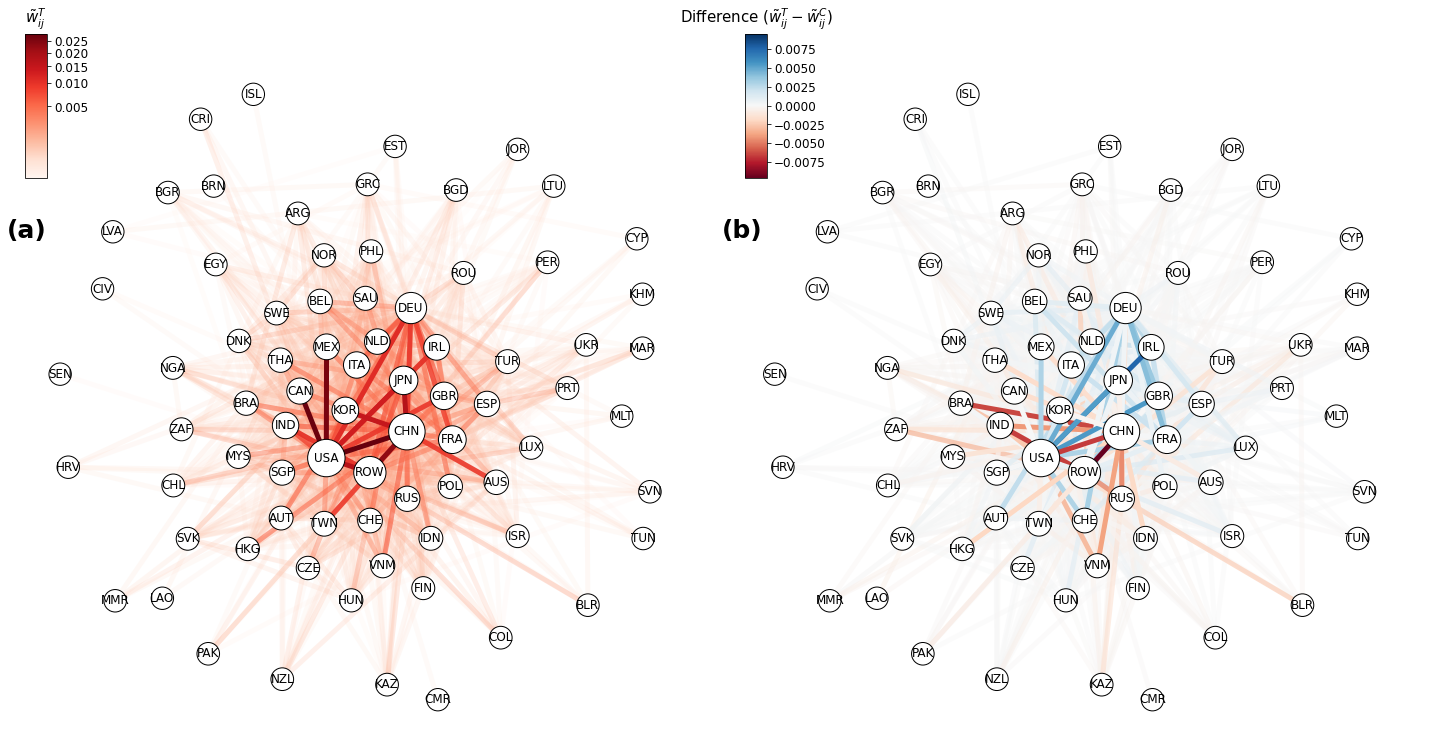

In [3]:
# Manual positions dictionary (truncated here for brevity; full one will be used)
manual_pos = {
    'DEU': np.array([0.12, 0.12]),
    'IRL': np.array([0.18, 0.12]),
    'AUT': np.array([-0.23104672, -0.30361848]),
    'BEL': np.array([-0.09655162,  0.2043621 ]),
    'CHE': np.array([ 0.04266046, -0.31867407]),
    'DNK': np.array([-0.38134392,  0.22913176]),
    'ESP': np.array([0.2604534 , 0.09692229]),
    'EST': np.array([0.08892224, 0.82523039]),
    'FIN': np.array([ 0.17332646, -0.57113555]),
    'FRA': np.array([0.14878472, 0.00143506]),
    'GBR': np.array([0.08151135, 0.07986617]),
    'GRC': np.array([0.00024567, 0.70603599]),
    'CYP': np.array([0.875564  , 0.53280654]),
    'CZE': np.array([-0.18922361, -0.49964736]),
    'ITA': np.array([0.01039003, 0.06876068]),
    'LUX': np.array([ 0.53207187, -0.12990284]),
    'LVA': np.array([-0.82866869,  0.55502096]),
    'ISL': np.array([-0.37164926,  0.99104663]),
    'SVK': np.array([-0.58527447, -0.41886675]),
    'SVN': np.array([ 0.91747159, -0.27443597]),
    'SWE': np.array([-0.21653502,  0.26205254]),
    'NOR': np.array([-0.14202977,  0.46915134]),
    'HUN': np.array([-0.04692379, -0.60700766]),
    'TUR': np.array([0.36457836, 0.08910717]),
    'UKR': np.array([0.7107703 , 0.19628967]),    
    'MLT': np.array([ 0.82652645, -0.02981567]),
    'POL': np.array([ 0.20942159, -0.23995477]),
    'PRT': np.array([0.64964034, 0.05921926]),
    'NLD': np.array([0.06132685, 0.18017971]),
    
    'ARG': np.array([-0.22640344,  0.61317012]),
    'BRA': np.array([-0.2,  0.05439842]),
    'CHL': np.array([-0.63202161, -0.24974074]),
    'BRN': np.array([-0.52149833,  0.6970305 ]),
    'COL': np.array([ 0.43298556, -0.7326094 ]),
    'PER': np.array([0.58524825, 0.45824772]),
    
    'MEX': np.array([ -0.16, 0.08]),
    'USA': np.array([ -0.1, 0.0]),
    'CAN': np.array([ -0.18, 0.05 ]),

    'ISR': np.array([ 0.48789009, -0.41032878]),
    'JOR': np.array([0.48785748, 0.81639086]),
    'TUN': np.array([ 0.8967636 , -0.41333016]),
    'SAU': np.array([0.03082744, 0.27511489]),
   
    
    'CHN': np.array([0.1, 0]),
    'JPN': np.array([0.0, 0.1]),
    'RUS': np.array([ 0.08104859, -0.24397456]),

    'TWN': np.array([-0.11589567, -0.35486421]),
    'VNM': np.array([ 0.0408335 , -0.44860449]),
    'AUS': np.array([ 0.29415445, -0.24223707]),
    'NZL': np.array([-0.27760796, -0.86430306]),
    'HKG': np.array([-0.35861003, -0.42046018]),
    'THA': np.array([-0.18239529,  0.07167459]),
    'KOR': np.array([ 0.0652344 , -0.18145015]),
    'LAO': np.array([-0.66754088, -0.60748323]),
    'MMR': np.array([-0.8210662 , -0.61553941]),
    'MYS': np.array([-0.40330553, -0.16239305]),
    'SGP': np.array([-0.22612731, -0.16863491]),
    'IDN': np.array([ 0.20011427, -0.40919217]),
    'IND': np.array([-0.1684894 , -0.05390901]),
    'KAZ': np.array([ 0.06324659, -0.88160371]),
    'PAK': np.array([-0.5183063 , -0.78369465]),
    
    
    'BGD': np.array([0.28802857, 0.68741961]),
    'BGR': np.array([-0.62835316,  0.6822907 ]),
    'BLR': np.array([ 0.71636109, -0.62945546]),
    'CIV': np.array([-0.86203222,  0.37411375]),
    'CMR': np.array([ 0.22845213, -0.9293595 ]),
    'CRI': np.array([-0.54315   ,  0.91202532]),
    'EGY': np.array([-0.49385557,  0.45129487]),
    'HRV': np.array([-0.97356453, -0.19184372]),
    'KHM': np.array([0.89410405, 0.35690782]),
    'LTU': np.array([0.60533782, 0.69997599]),
    'MAR': np.array([0.8941845 , 0.18562102]),
    'NGA': np.array([-0.63348315,  0.12325164]),
    'PHL': np.array([0.00463573, 0.40250398]),
    'ROU': np.array([0.31185773, 0.42448583]),
    'SEN': np.array([-1.0, 0.10333235]),
    'ZAF': np.array([-0.6052995 , -0.07161981]),
    
    'ROW': np.array([0.0, -0.1 ]),

}

# Adjust manual positions to enforce 0.15 minimum distance
adjusted_pos = enforce_min_node_distance(manual_pos, min_dist=0.15)
adjusted_pos['KOR'][1]+=0.05
adjusted_pos['KOR'][0]-=0.05
adjusted_pos['CAN'][0]-=0.05
adjusted_pos['ITA'][1]+=0.05

# Plot the Networks
fig = create_combined_plots(
    # Enhanced network parameters
    G1=G[2019],
    # G2=G_ghg[2019], 
    pos=adjusted_pos,
    threshold_enhanced=0.0001,
    cmap_enhanced='Reds',
    
    # Difference network parameters
    G_T=G[2019],
    G_C=G_ghg[2019],
    threshold_diff=0.0,
    cmap_diff='RdBu',
    gamma=2,
    cbar_label_diff=r"Difference ($\tilde{w}^T_{ij} - \tilde{w}^C_{ij})$",
    
    # Make difference network edges darker
    darken_diff_edges=True,
    diff_alpha_multiplier=2,  # Increase this value to make edges even darker
    
    # Combined figure parameters
    figsize=(20, 10)
)
# fig.savefig('fig_2_network.png', bbox_inches='tight')

# Figure 2: Link Weight Distribution and Similarity Measures

/Users/nk821/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


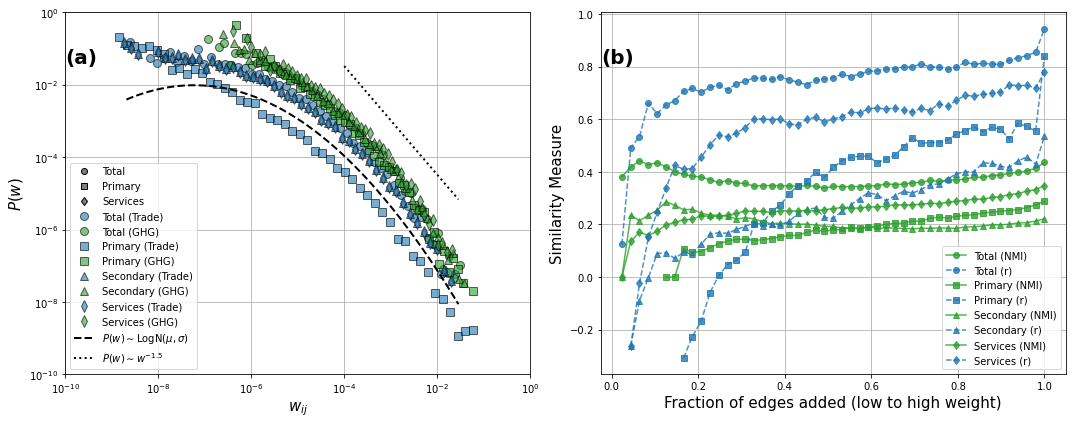

In [4]:
# Prepare data
sector_matrices = {
    "Total": (nx.to_numpy_array(G[2019], weight='weight'), nx.to_numpy_array(G_ghg[2019], weight='weight')),
    "Primary": (nx.to_numpy_array(G_primary[2019], weight='weight'), nx.to_numpy_array(G_primary_ghg[2019], weight='weight')),
    "Secondary": (nx.to_numpy_array(G_secondary[2019], weight='weight'), nx.to_numpy_array(G_secondary_ghg[2019], weight='weight')),
    "Services": (nx.to_numpy_array(G_services[2019], weight='weight'), nx.to_numpy_array(G_services_ghg[2019], weight='weight'))
}

sector_graphs = {
    "Total": (G[2019], G_ghg[2019]),
    "Primary": (G_primary[2019], G_primary_ghg[2019]),
    "Secondary": (G_secondary[2019], G_secondary_ghg[2019]),
    "Services": (G_services[2019], G_services_ghg[2019])
}

colors = {
    "Trade": {'Total': '#1f77b4', 'Primary': '#1f77b4AA', 'Secondary': '#1f77b499', 'Services': '#1f77b477'},
    "GHG": {'Total': '#2ca02c', 'Primary': '#2ca02cAA', 'Secondary': '#2ca02c99', 'Services': '#2ca02c77'}
}

markers = {"Total": 'o', "Primary": 's', "Secondary": '^', "Services": 'd'}

linestyles = {
    "Total": '-',
    "Primary": '--',
    "Secondary": '-.',
    "Services": ':'
}
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1]})

# Left plot: empirical distributions
for sector, (W_trade, W_ghg) in sector_matrices.items():
    for W, label in zip([W_trade, W_ghg], ['Trade', 'GHG']):
        weights = clean_weights(W)
        logbins = np.logspace(np.log10(min(weights)), np.log10(max(weights)), 50)
        hist, bin_edges = np.histogram(weights, bins=logbins, density=True)
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
        axs[0].plot(
            bin_centers, hist / np.sum(hist),
            marker=markers[sector],
            markersize=8,
            linestyle='',
            label=f"{sector} ({label})",
            color=colors[label][sector],
            markeredgecolor='black',
            alpha=0.6
        )
        
# Fit log-normal to Total Trade sector
weights_total_trade = clean_weights(sector_matrices["Total"][0])  # Total Trade weights
shape, loc, scale = lognorm.fit(weights_total_trade, floc=0)
mu = np.log(scale)
sigma = shape

# Plot log-normal PDF
w_vals = np.logspace(np.log10(min(weights_total_trade)), np.log10(max(weights_total_trade)), 300)
pdf_vals = lognorm.pdf(w_vals, s=sigma, loc=0, scale=np.exp(mu))
# pdf_vals /= np.trapz(pdf_vals, w_vals)  # Normalize
hist_vals, _ = np.histogram(weights_total_trade, bins=np.logspace(np.log10(min(weights_total_trade)), np.log10(max(weights_total_trade)), 50))
# scale_factor = max(hist_vals) / max(pdf_vals)

axs[0].plot(w_vals, pdf_vals/np.sum(pdf_vals), linestyle='--', color='black', label=r'$P(w) \sim \mathrm{LogN}(\mu, \sigma)$', linewidth=2)
# axs[0].text(0, 0.4, rf"$\mu$ = {mu:.2f}, $\sigma$ = {sigma:.2f}", fontsize=9)

# --- Power-law tail (for x > 1e-4)
x_tail = np.logspace(np.log10(1e-4), np.log10(max(weights_total_trade)), 300)
tau = 1.5
p_tail = x_tail ** (-tau)
p_tail /= np.trapz(p_tail, x_tail)  # Normalize
scale_tail = 0.0001* max(hist_vals) / max(p_tail)
axs[0].plot(x_tail, p_tail * scale_tail, linestyle=':', color='black', linewidth=2, label=r'$P(w)\sim w^{-1.5}$')

# ---- existing right subplot (cumulative metrics) ----
for sector, (G1, G2) in sector_graphs.items():
    fracs_nmi, vals_nmi = compute_cumulative_metric(G1, G2, custom_nmi_wrapper)
    fracs_p, vals_p = compute_cumulative_metric(G1, G2, pearson_wrapper)
    
    axs[1].plot(fracs_nmi, vals_nmi, label=f"{sector} (NMI)", linestyle='-', 
                marker=markers[sector], color=colors['GHG'][sector], alpha=0.8)
    axs[1].plot(fracs_p, vals_p, label=f"{sector} (r)", linestyle='--', 
                marker=markers[sector], color=colors['Trade'][sector], alpha=0.8)

axs[1].set_xlabel("Fraction of edges (low to high weight)")
axs[1].set_ylabel("Similarity Measure")
# axs[1].set_title("Cumulative NMI and Pearson Correlation")
axs[1].grid(True)
axs[1].legend(fontsize=8)

# # ---- add inset ----
# inset_ax = inset_axes(axs[1], width="40%", height="40%", loc='upper right', borderpad=2)

# for sector, (G1, G2) in sector_graphs.items():
#     fracs_nmi, vals_nmi = compute_cumulative_metric(G1, G2, custom_nmi_wrapper)
#     fracs_p, vals_p = compute_cumulative_metric(G1, G2, pearson_wrapper)

#     # Filter for fraction > 0.8
#     fnmi = [(x, y) for x, y in zip(fracs_nmi, vals_nmi) if x >= 0.9]
#     fp = [(x, y) for x, y in zip(fracs_p, vals_p) if x >= 0.9]
#     if fnmi and fp:
#         xnmi, ynmi = zip(*fnmi)
#         xp, yp = zip(*fp)

#         inset_ax.plot(xnmi, ynmi, linestyle='-', marker=markers[sector],
#                       color=colors['GHG'][sector], alpha=0.9, linewidth=1)
#         inset_ax.plot(xp, yp, linestyle='--', marker=markers[sector],
#                       color=colors['Trade'][sector], alpha=0.9, linewidth=1)

# inset_ax.set_title("Zoom: Top Edge Fractions", fontsize=9)
# inset_ax.tick_params(labelsize=8)
# inset_ax.grid(True)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$w_{ij}$", fontsize=15)
axs[0].set_ylabel(r"$P(w)$", fontsize=15)
# axs[0].set_title("Empirical Weight Distributions (2019)")
axs[0].grid(True)
axs[0].set_xlim([1e-10, 1])
axs[0].set_ylim([1e-10, 1])
axs[0].text(0.0, 0.9, "(a)", transform=axs[0].transAxes,
              fontsize=20, fontweight='bold', va='top', ha='left')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Total', markerfacecolor='gray', markeredgecolor='black', markersize=6),
    Line2D([0], [0], marker='s', color='w', label='Primary', markerfacecolor='gray', markeredgecolor='black', markersize=6),
    Line2D([0], [0], marker='d', color='w', label='Services', markerfacecolor='gray', markeredgecolor='black', markersize=6),
]
axs[0].legend(handles=legend_elements + axs[0].get_legend_handles_labels()[0], fontsize=10)

axs[1].set_xlabel("Fraction of edges added (low to high weight)",fontsize=15 )
axs[1].set_ylabel("Similarity Measure",fontsize=15)
# axs[1].set_title("Cumulative NMI and Pearson Correlation")
axs[1].grid(True)
axs[1].legend(fontsize=10)
axs[1].text(0.0, 0.9, "(b)", transform=axs[1].transAxes,
              fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()
# fig.savefig('fig2_sim.png')


# Figure 3: Node strengths scaling with link weights

/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


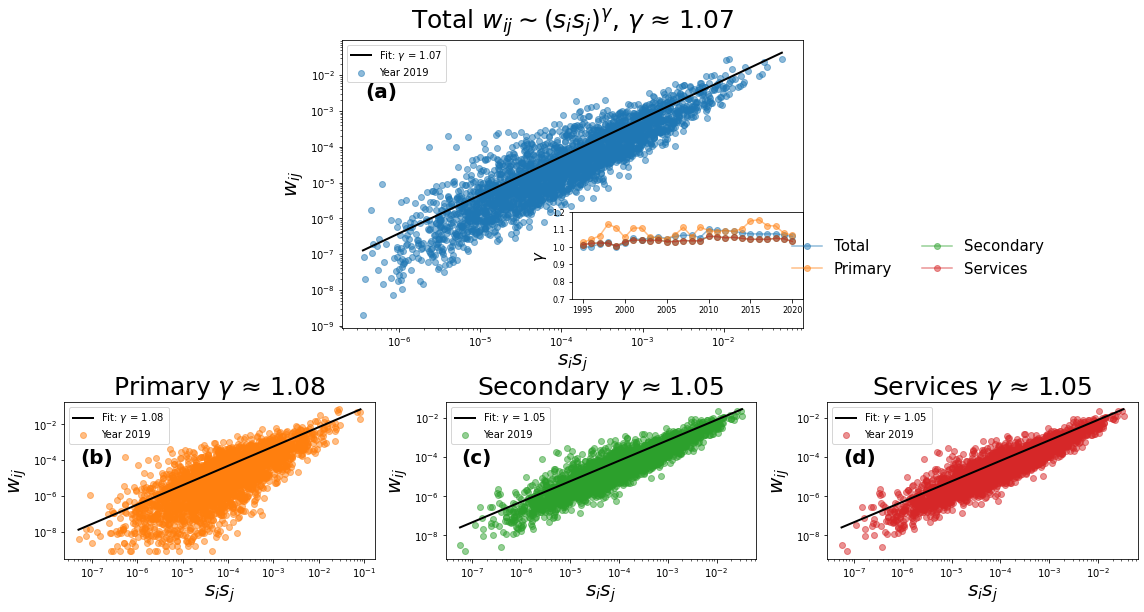

/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


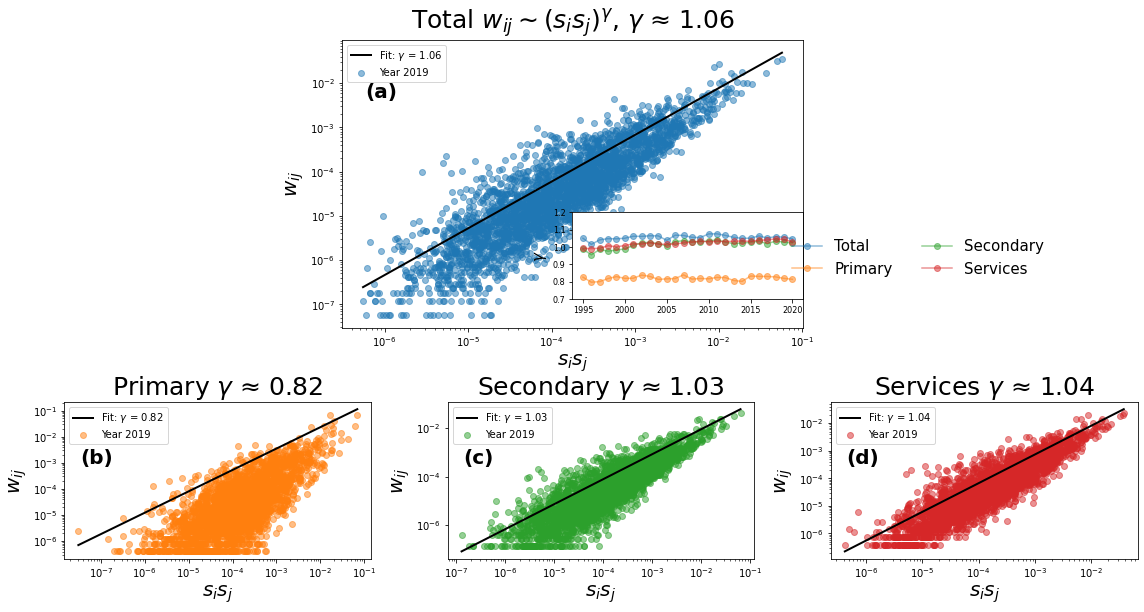

In [5]:
years = sorted(df_total['year'].unique())

scaling_gamma(df_total, df_primary, df_secondary, df_services)
scaling_gamma(df_total_ghg, df_primary_ghg, df_secondary_ghg, df_services_ghg)


# Figure 4: Rich-club Coefficients

/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:763: RuntimeWarning: Mean of empty slice
  rc_mean = np.nanmean(rc_all, axis=0)
/Users/nk821/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:763: RuntimeWarning: Mean of empty slice
  rc_mean = np.nanmean(rc_all, axis=0)
/Users/nk821/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/nk821/Documents/Emissions Trade Model/OECD/functions.py:763: RuntimeWarning: Mean of empty slice
  rc_mean = np.nanmean(rc_all, axis=0)
/Users/nk821/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Use

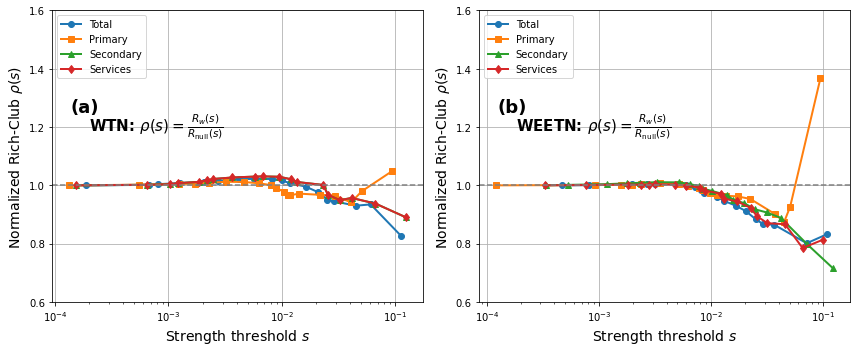

In [7]:
# === Load Data ===
# Load results from simulations of the Null-Model

colors = {
    "Total": '#1f77b4',
    "Primary": '#ff7f0e',
    "Secondary": '#2ca02c',
    "Services": '#d62728'
}
markers = {
    "Total": 'o',
    "Primary": 's',
    "Secondary": '^',
    "Services": 'd'
}
year=2019
with open("Data/Total/Pickles/3_alphabeta_parallel_{}_n100.pkl".format(year), "rb") as f:
    results_total = pickle.load(f)
    
with open("Data/Primary/Pickles/3_alphabeta_parallel_{}_n100.pkl".format(year), "rb") as f:
    results_primary = pickle.load(f)

with open("Data/Secondary/Pickles/3_alphabeta_parallel_{}_n100.pkl".format(year), "rb") as f:
    results_secondary = pickle.load(f)
    
with open("Data/Services/Pickles/3_alphabeta_parallel_{}_n100.pkl".format(year), "rb") as f:
    results_services = pickle.load(f)
    
# === Plot Setup ===

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_all_rich_club(axs[0], df_total, results_total[:100], "Total", year=1995, var='weight', color=colors["Total"], marker=markers["Total"])
plot_all_rich_club(axs[0], df_primary, results_primary[:100], "Primary", year=1995, var='weight', color=colors["Primary"], marker=markers["Primary"])
plot_all_rich_club(axs[0], df_secondary, results_secondary[:100], "Secondary", year=1995, var='weight', color=colors["Secondary"], marker=markers["Secondary"])
plot_all_rich_club(axs[0], df_services, results_services[:100], "Services", year=1995, var='weight', color=colors["Services"], marker=markers["Services"])

# GHG share plots
plot_all_rich_club(axs[1], df_total_ghg, results_total[:100], "Total", year=1995, var='weight', color=colors["Total"], marker=markers["Total"])
plot_all_rich_club(axs[1], df_primary_ghg, results_primary[:100], "Primary", year=1995, var='weight', color=colors["Primary"], marker=markers["Primary"])
plot_all_rich_club(axs[1], df_secondary_ghg, results_secondary[:100], "Secondary", year=1995, var='weight', color=colors["Secondary"], marker=markers["Secondary"])
plot_all_rich_club(axs[1], df_services_ghg, results_services[:100], "Services", year=1995, var='weight', color=colors["Services"], marker=markers["Services"])

# Formatting plots
lab = ['WTN', 'WEETN']
for i, ax in enumerate(axs.flat):
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend(loc="upper left", fontsize=10)
    ax.axhline(1.0, linestyle='--', color='gray')
    ax.set_ylabel(r"Normalized Rich-Club $\rho(s)$", fontsize=14)

    ax.set_xlabel(r"Strength threshold $s$", fontsize=14)
    ax.text(0.05, 0.7, f"({chr(97+i)})", transform=ax.transAxes,
            fontsize=18, fontweight='bold', va='top', ha='left')
    ax.text(0.1, 0.6, r"{}: $\rho(s) = \frac{{R_w(s)}}{{R_{{\mathrm{{null}}}}(s)}}$".format(lab[i]), 
            transform=ax.transAxes, fontsize=15, fontweight='bold', va='center', ha='left')
    ax.set_ylim([0.6, 1.6])

plt.tight_layout()
plt.show()
# fig.savefig('fig5_rho.png', dpi=300)


# Figure 4.1 (Appendix Figure): Null model and Strength or link weight distributions

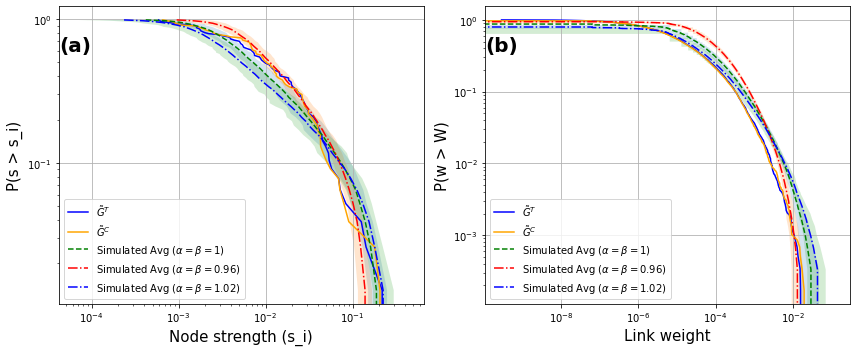

In [12]:
year=2019
with open("Data/Total/Pickles/31_alphabeta_parallel_{}_n100.pkl".format(year), "rb") as f:
    results_total = pickle.load(f)

# === Run Comparison ===

sim_graphs_alpha1 = [convert_sim_result_to_graph(r) for r in results_total[:100]]
sim_graphs_alpha096 = [convert_sim_result_to_graph(r) for r in results_total[400:500]]
sim_graphs_alpha102 = [convert_sim_result_to_graph(r) for r in results_total[800:900]]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
G_trade_2019 = G_dir[2019]
G_ghg_2019 = G_ghg_dir[2019]

# Real networks
plot_cumulative_node_strength_from_graph(G_trade_2019, ax=axs[0], label=r'$\tilde{G}^T$', color='blue')
plot_cumulative_link_weight_from_graph(G_trade_2019, ax=axs[1], label=r'$\tilde{G}^T$', color='blue')
plot_cumulative_node_strength_from_graph(G_ghg_2019, ax=axs[0], label=r'$\tilde{G}^C$', color='orange')
plot_cumulative_link_weight_from_graph(G_ghg_2019, ax=axs[1], label=r'$\tilde{G}^C$', color='orange')

# Simulated (α = 1)
plot_avg_sorted_node_strength(sim_graphs_alpha1, ax=axs[0], label=r'Simulated Avg ($\alpha=\beta=1$)', linestyle='--', color='green')
plot_avg_sorted_link_weight(sim_graphs_alpha1, ax=axs[1], label=r'Simulated Avg ($\alpha=\beta=1$)', linestyle='--', color='green')

# Simulated (α = 0.96)
plot_avg_sorted_node_strength(sim_graphs_alpha096, ax=axs[0], label=r'Simulated Avg ($\alpha=\beta=0.96$)', linestyle='-.', color='red')
plot_avg_sorted_link_weight(sim_graphs_alpha096, ax=axs[1], label=r'Simulated Avg ($\alpha=\beta=0.96$)', linestyle='-.', color='red')

# Simulated (α = 1.02)
plot_avg_sorted_node_strength(sim_graphs_alpha102, ax=axs[0], label=r'Simulated Avg ($\alpha=\beta=1.02$)', linestyle='-.', color='blue')
plot_avg_sorted_link_weight(sim_graphs_alpha102, ax=axs[1], label=r'Simulated Avg ($\alpha=\beta=1.02$)', linestyle='-.', color='blue')

# Formatting
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend(fontsize=10)

axs[0].set_xlabel(r"Node strength (s_i)", fontsize=15)
axs[0].set_ylabel(r"P(s > s_i)", fontsize=15)
# axs[0].set_title("Cumulative Node Strength Distribution")
axs[0].text(0.0, 0.9, "(a)", transform=axs[0].transAxes,
              fontsize=20, fontweight='bold', va='top', ha='left')

axs[1].set_xlabel("Link weight", fontsize=15)
axs[1].set_ylabel("P(w > W)", fontsize=15)
# axs[1].set_title("Cumulative Link Weight Distribution")
axs[1].text(0.0, 0.9, "(b)", transform=axs[1].transAxes,
              fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()
# fig.savefig('fig8_null.png', dpi=300)


# Figure 5: Inequity Degree and GDP_pc rank

   node  inequity  gdppc_exp  rank  k_ineq
65  LAO    5.0491   8075.275    66      51


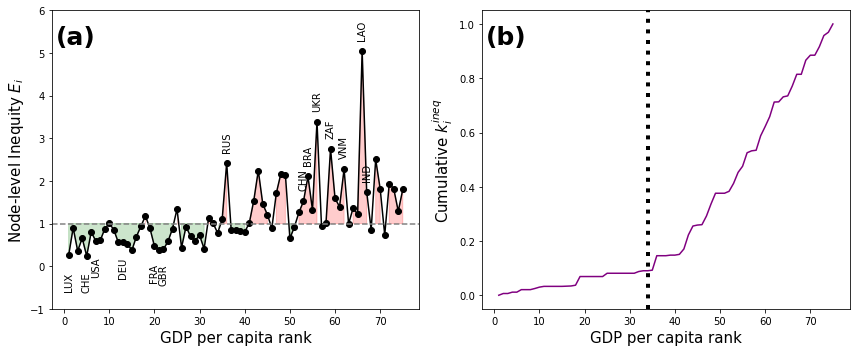

Group-to-Group Flow Summary (2019):


,G1 → G1,G1 → G2,G2 → G1,G2 → G2
Trade,0.375426,0.224025,0.219805,0.180744
Emissions,0.223916,0.159613,0.317400,0.299072


Group-to-Group Flow Summary(1995):


,G1 → G1,G1 → G2,G2 → G1,G2 → G2
Trade,0.572421,0.191846,0.169754,0.065979
Emissions,0.369481,0.132588,0.347725,0.150205


In [13]:
G_trade = G_dir[2019]
G_ems = G_ghg_dir[2019]

inequity = compute_node_inequity(G_trade, G_ems)
inequity_df = pd.DataFrame(list(inequity.items()), columns=['node', 'inequity'])

# Merge with gdppc_ex from merged_df
gdppc_df = merged_df[merged_df['year'] == 2019][['Source', 'gdppc_exp']].drop_duplicates().rename(columns={'Source': 'node'})
final_df = pd.merge(inequity_df, gdppc_df, on='node', how='left')

# Run the GDP vs Inequity and Degree plots
plot_inequity_and_degree(G_trade, G_ems, merged_df)

# Get the DataFrame with inequity values
inequity_data = get_inequity_df(G_trade, G_ems, merged_df)

# Ensure you have this DataFrame from earlier
gdppc_df = merged_df[merged_df['year'] == 2019][['Source', 'gdppc_exp']].drop_duplicates().rename(columns={'Source': 'node'})
gdppc_df_95 = merged_df[merged_df['year'] == 1995][['Source', 'gdppc_exp']].drop_duplicates().rename(columns={'Source': 'node'})

# Sort and assign ranks
gdppc_df = gdppc_df.sort_values(by='gdppc_exp', ascending=False).reset_index(drop=True)
gdppc_df['rank'] = gdppc_df.index + 1  # Rank starts at 1
gdp_rank_dict = dict(zip(gdppc_df['node'], gdppc_df['rank']))

gdppc_df_95 = gdppc_df_95.sort_values(by='gdppc_exp', ascending=False).reset_index(drop=True)
gdppc_df_95['rank'] = gdppc_df_95.index + 1  # Rank starts at 1
gdp_rank_dict_95 = dict(zip(gdppc_df_95['node'], gdppc_df_95['rank']))

# Split countries based on GDP rank
threshold_rank = 35
inequity_data = inequity_data.dropna(subset=['gdppc_exp'])
inequity_data = inequity_data.sort_values(by='gdppc_exp', ascending=False).reset_index(drop=True)
inequity_data['rank'] = np.arange(1, len(inequity_data) + 1)

group1 = set(inequity_data[inequity_data['rank'] <= threshold_rank]['node'])
group2 = set(inequity_data[inequity_data['rank'] > threshold_rank]['node'])

group2.add("ROW")
group2.add("TWN")


# Compute for trade and emissions
trade_flows = compute_group_weights(G_trade, group1, group2)
ghg_flows = compute_group_weights(G_ems, group1, group2)

# Present as DataFrame
flows_df = pd.DataFrame([trade_flows, ghg_flows], index=['Trade', 'Emissions'])
print("Group-to-Group Flow Summary (2019):")
display(flows_df)

G_trade = G_dir[1995]
G_ems = G_ghg_dir[1995]

trade_flows = compute_group_weights(G_trade, group1, group2)
ghg_flows = compute_group_weights(G_ems, group1, group2)

# Present as DataFrame
flows_df = pd.DataFrame([trade_flows, ghg_flows], index=['Trade', 'Emissions'])
print("Group-to-Group Flow Summary(1995):")
display(flows_df)


# Figure 6: Trophic Levels and Coherence 



Top 5 countries in trophic level:
AUT: 1.31
DEU: 1.30
GBR: 1.29
SVN: 1.29
SWE: 1.29
CYP: 1.29
FRA: 1.28
CHE: 1.27
ISR: 1.27
ITA: 1.27
IRL: 1.24
BEL: 1.24
MLT: 1.23
HRV: 1.23
Bottom 5 countries in trophic level:
KAZ: 0.00
UKR: 0.00
LAO: 0.03
RUS: 0.07
BRA: 0.07
ZAF: 0.10
MMR: 0.11
ARG: 0.11
TWN: 0.14
VNM: 0.15
Spearman correlation between GDP rank and trophic level (Total): rho = -0.56, p = 0.0000
Spearman correlation between GDP rank and trophic level (Primary): rho = -0.25, p = 0.0292
Spearman correlation between GDP rank and trophic level (Secondary): rho = -0.39, p = 0.0005
Spearman correlation between GDP rank and trophic level (Services): rho = -0.29, p = 0.0111


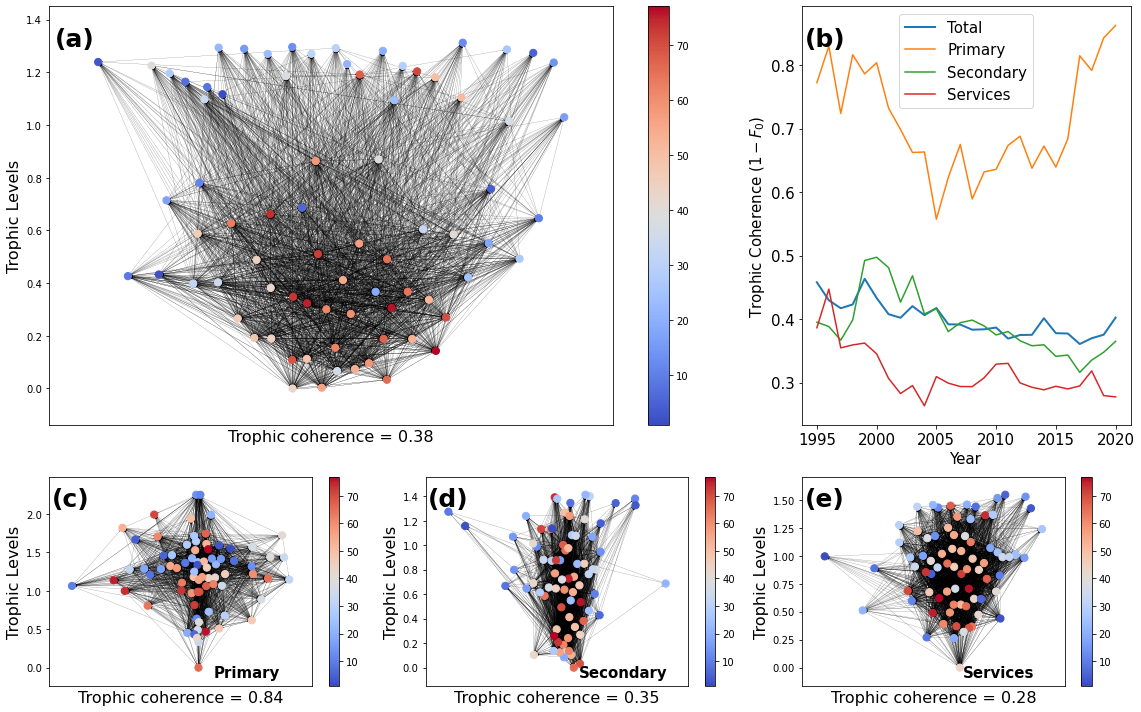

,Year,F_0
0,1995,0.542060
1,1996,0.570460
2,1997,0.582949
3,1998,0.577012
4,1999,0.536589
5,2000,0.566778
6,2001,0.592353
7,2002,0.597983
8,2003,0.579594
9,2004,0.593895


In [14]:
plot_trophic_overview(
    G_dir, G_ghg_dir,
    G_primary_dir, G_primary_ghg_dir,
    G_secondary_dir, G_secondary_ghg_dir,
    G_services_dir, G_services_ghg_dir,
    gdp_rank_dict=gdp_rank_dict
)